## 1. Introduction

### 1.1 Problem Statement
To develop Predictive Models to understand how a customer's historical spending behaviour influence their total spending, in order to predict the revenue of Retail Hypermarket for the upcoming quarter.

### 1.2 Objectives: 
> 1.2.1 Understand how factors influence customer spendings.

> 1.2.2 Predict total spending of customers for upcoming quarter.

> 1.2.3 Devise plans to maximise business revenue for upcoming quarters.

### 1.3 Goal of project: 
1.3.1 Task: To create a white-box Linear Regression (LR) model (LR) and a black-box Decision Tree Regression (DTR) model that **predicts an estimate total spending per transaction by each customer based on their past spending behaviour**.

1.3.2 Goal for Deployment: **Extrapolate future revenue** using historical customer engagement data. This prediction will enable Business Analysts to make informed decisions and optimize revenue for upcoming quarters.

### 1.4 Scope of project:
1.4.1 Formulate: Predictors used for the models should be **related to customer behaviour and relevant to their total spending**. These may include customer spending habits, product details, and seasonal factors. The **features should be readily available and accessible** by the Models. Hence, the features must be within, or is easily generated using the dataset provided.

1.4.2 Target leakage: **predictors should be available before time of prediction**. This means that features like the year of purchase or features directly related to the target variable should not be used as predictors. Predictors like **Product_ID and Customer_ID should not be exact as it is unfeasible** to pin-point the exact customer or product when predicting.

1.4.3 The **models should be tested on data beyond the training dataset** to **ensure they can generalize** and perform consistently well with unseen data before deployment.

1.4.4 The models should **adhere to AI ethics and regulations**, ensuring transparency, fairness, absence of bias, and non-discrimination. Customer attributes like race should not be used to treat customers unfairly.

### 1.5 Performance:
1.5.0 Key Metric: **R^2 to assess a Model's ability to capture customer engagement patterns** thereby ability to make reliable predictions. The goal is to **achieve a high goodness of fit without overfitting**.

1.5.1 Mean Absolute Error (MAE) will be used to assess the average prediction error and Root Mean Squared Error (RMSE) will assess the model's ability to handle outliers effectively.

1.5.2 A **model's accuracy is only assessed after it meets satisfactory standards** for its R^2 and MAE, justifying the model to be considered to proceed to the next stage.

1.5.3 A **LR Model should prioritize interpretability**. It should have an R^2 above 0.8 and an accuracy above 80% to be considered for deployment.

1.5.4 A **DTR Model should prioritize predictive power while maintaining interpretability**. It should have an R^2 above 0.85 and an accuracy above 90% to be considered for deployment.

1.5.5 Success Criteria: Models must **demonstrate a good fit**, **meet accuracy requirements**, and **perform consistently well on both training and validation datasets** to ensure they are well-generalized and ready for deployment.

### 1.6 Environment:
1.6.1 A model should be **usable in the real world**, even if some predictors are slightly off. It should be **well-generalized, without concerning overfitting or underfitting issues**.

1.6.2 A model should be **adaptable to handle increased of data volume and computational requirements** as usage grows; it should be scalable without performance degradation.

1.6.3 Training datasets and **data for model evaluation should be current** to ensure that insights from the models remain relevant and reflective of current conditions.

1.6.4 The model should be designed to be **robust against inconsistencies, outliers, and adaptable to changes in data patterns**. To achieve this, techniques like normalization and regularization will be employed if needed.

1.6.5 The model should **solve business problem/requirements**. It should be **well-documented for business users to understand** and **easily adjustable** to accommodate changes over time.

## 2. Data Attributes

### 2.1 Data Understanding
The dataset 'synthetic_data.csv' was provided by Retail Hypermarket, which contains the company's transaction records from 2021 to 2022. A data dictionary, attached below, has also been provided for understanding what each column represents.

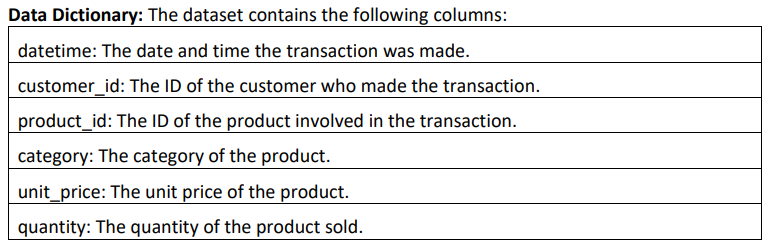

### 2.2 Data Inspection

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [2]:
# loading dataset in df
df = pd.read_csv('synthetic_data.csv')
print("1. Number of observations: ", len(df))

1. Number of observations:  331664


In [3]:
# EDA on df
pd.set_option('display.float_format', '{:.10f}'.format) # show full unit_price without truncation
print("2. First 5 rows of the dataset:")
df.head()

2. First 5 rows of the dataset:


,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
0,2022-01-07,10106959,Stationery,9,1.5798753892,a225207859
1,2022-01-09,90097406,Sports,4,196.2533774599,a225207859
2,2022-01-10,10010465,Electronics,1,825.3742907058,a225207859
3,2022-01-14,10010510,Electronics,2,325.9650346646,a225207859
4,2022-01-16,40049430,Books,1,22.6019194627,a225207859


In [4]:
pd.set_option('display.float_format', '{:.2f}'.format) # revert

In [5]:
print("3. Check for data types and missing values: \n")
df.info()

3. Check for data types and missing values: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331664 entries, 0 to 331663
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Datetime     331664 non-null  object 
 1   Product_ID   331664 non-null  int64  
 2   Category     331664 non-null  object 
 3   Quantity     331664 non-null  int64  
 4   Unit_Price   331664 non-null  float64
 5   Customer_ID  331664 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 15.2+ MB


In [6]:
print("4. Summary statistics for numerical columns: \n")
print(df.describe())

4. Summary statistics for numerical columns: 

       Product_ID  Quantity  Unit_Price
count   331664.00 331664.00   331664.00
mean  30263284.24      9.13      124.09
std   20838500.39      6.59      270.82
min   10010000.00      1.00        1.00
25%   20022495.00      2.00        8.91
50%   20026550.00     10.00       14.91
75%   40041557.25     15.00       47.86
max   90099999.00     20.00     1199.95


In [7]:
print("5. Check count of distinct values:")
df.nunique()

5. Check count of distinct values:


Datetime          368
Product_ID      75781
Category           10
Quantity           20
Unit_Price     331664
Customer_ID      2648
dtype: int64

In [8]:
# Checking if all Products have same price
Product = df.sort_values(by=['Product_ID'])
Product.head(4)

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID
126708,2022-05-22,10010000,Electronics,2,850.91,a704811449
326206,2022-05-26,10010000,Electronics,2,357.38,c567078712
173955,2022-09-06,10010000,Electronics,1,495.94,c849466466
105432,2022-11-07,10010000,Electronics,1,791.22,d703549797


#### 2.2.1 Issues:
> 1. Datetime column only contains date and is **missing time values**.
2. Datetime column is **not parsed in proper format**.
3. **Unit_Price is a non-terminating number**. This is strange as its unconventional for prices at supermarkets to go beyond cents. Hence, Unit_Price should be rounded off to 2 d.p.
4. Price of product changes over time. This indicates that **different discounts were given to different customers**.

#### 2.2.2 Evaluation:
> 1. There are **NO MISSING VALUES**.
2. There are **little features** provided in dataset, however there are **opportunities to create new features**.
3. Apart from Datetime, all features look fine on an overview level as the match the meaning of the column as stipulated in given data dictionary.
4. Quantity only has a range of 1 to 20.
5. There are only 10 types of product categories.
6. There are no negative quantity values, indicating **no refund transactions**.
7. The **data is recent**, hence relevant and applicable for current usage.
8. There is **sufficient rows for dataset to be split into training and testing** sets.

### 2.3 Data Cleaning
2.3.1 There is nothing that can be done about missing time, as there is no assessible data available to extract time for each transaction.

#### 2.3.2 Parsing Datetime to Date:

In [9]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

#### 2.3.3 Rounding Unit_Price to 2 d.p:

In [10]:
df['Unit_Price'] = round(df['Unit_Price'], 2)

#### 2.3.4 Accounting for discount in each transaction:

In [11]:
# Find the maximum unit price for each product_id
max_prices = df.groupby('Product_ID')['Unit_Price'].transform('max')

# Calculate the discount for each row
df['Discount'] = max_prices - df['Unit_Price']

#### 2.3.5 Removing discount:

In [12]:
# new col for original price, keep Unit_Price for future usage
df['Original_Unit_Price'] = df['Unit_Price'] + df['Discount']

### 2.4 Creation of Fields
In order for my base-line model to answer the problem statement, I require some new fields to simplify EDA.

#### 2.4.1 Creation of Target Column: Total_Spent
Required for answering problem statement of understanding how customer behaviour/engagement affect Retail Hypermarket's revenue.

In [13]:
df['Total_Spent'] = df['Quantity'] * df['Unit_Price']

#### 2.4.2 Month:
To assess whether customers' spending behavior varies across seasons, which is pertinent to our goal of predicting revenue for the upcoming quarter. This analysis aims to understand the potential impact of seasonal factors on sales revenue and helps determine whether I should include seasonal factors into my models.

In [14]:
df['Month'] = df['Datetime'].dt.month

### 2.5 Exploratory Data Analysis

#### 2.5.0 A) Examine df:

In [15]:
df.head(2)

,Datetime,Product_ID,Category,Quantity,Unit_Price,Customer_ID,Discount,Original_Unit_Price,Total_Spent,Month
0,2022-01-07,10106959,Stationery,9,1.58,a225207859,11.07,12.65,14.22,1
1,2022-01-09,90097406,Sports,4,196.25,a225207859,0.00,196.25,785.00,1


#### 2.5.0 B) Correlation Test

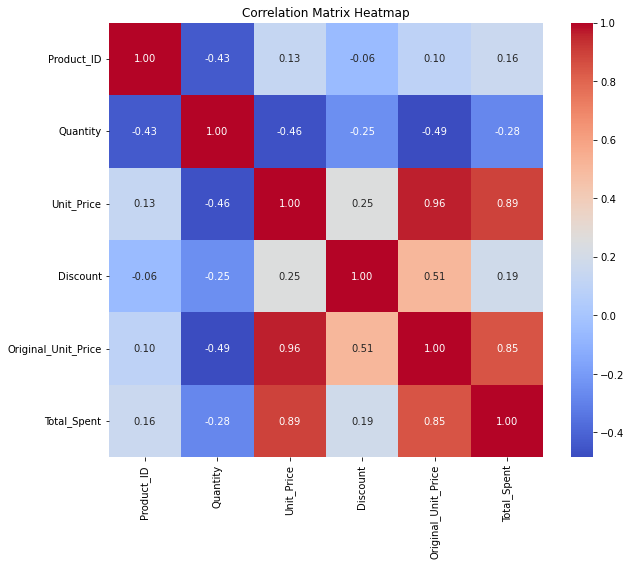

In [25]:
corr_matrix = df.drop(columns=['Month', 'Product_ID']).corr()         # pearson corr ONLY FOR CONTINUOUS
plt.figure(figsize=(10, 8))                                           # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

C) Analysis:
- **Unit_Price has high correlation with Total_Spent** because it is used for deriving the Total_Spent column.
- I **cannot use both Quantity and Unit_Price as predictors at the same time** as it would be target leakage; If I know the value for both features, I can calculate the total spent without the use of predictive models.

Since I cannot explore non-continuous features statistically due to limitations of Pearsons' Correlation, I will analyze the pattern of these columns through visualisations:
1. Month
2. Category
3. Customer ID
4. Product ID

#### 2.5.1 EDA Graph Plotter:

In [17]:
def eda_plot(category, measure, plot_type='line', measurement='sum'):
    category_revenue = df.groupby(category)[measure].agg(measurement)    # Aggr the measure per category based on measurement
    plt.figure(figsize=(16, 6))                                          # Set the size of the graph
    
    # Toggle to the selected chart
    if plot_type == 'line':
        plt.plot(category_revenue.index, category_revenue.values, marker='o', linestyle='-')
        plt.grid(True)                                                   # turn on grid for easy readibility
        
    elif plot_type == 'bar':
        category_revenue = category_revenue.sort_values(ascending=False) # Sort the data in descending order
        plt.bar(category_revenue.index, category_revenue.values)
        
    else:
        print("Invalid plot_type. Please use 'line' or 'bar'.")          # error tolerance
        return
    
    # Remove '_' for easier readibility of legends
    measure = measure.replace('_', ' ')
    category = category.replace('_', ' ')
    
    plt.title(f'{measurement.capitalize()} {measure} per {category}')
    plt.xlabel(category)
    plt.ylabel(measure)
    plt.xticks(category_revenue.index)
    plt.show()

#### Tutorial for EDA Graph Plotter:
> **eda_plot([Column in df], [measure, must be numerical], plot_type=[Type of Plot, line or bar, default=line], measurement=[measurement, sum/mean/median. default=sum])**

#### 2.5.2 Total Revenue per month
A) This graph aims to answer the following question:
- Is there a discernable monthly spending pattern that can be observed?

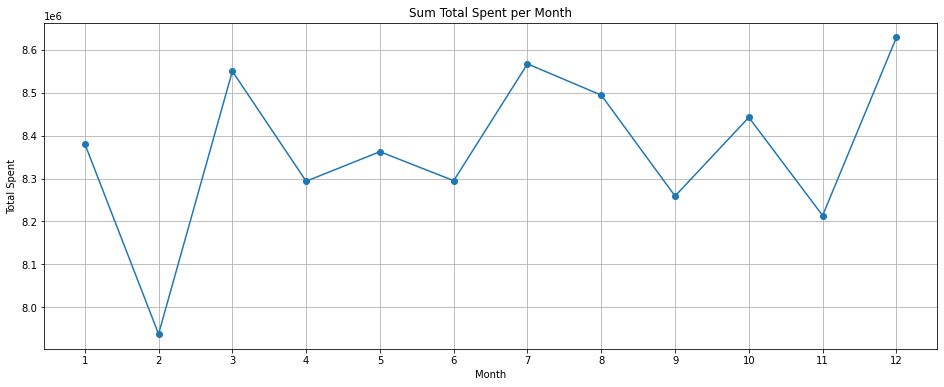

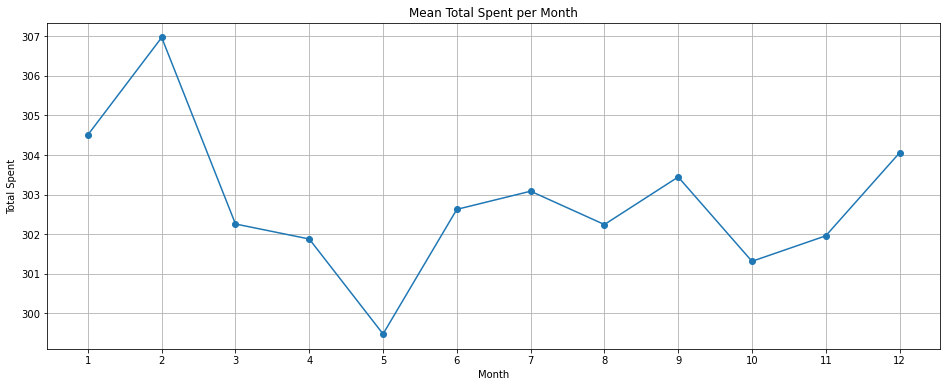

In [18]:
eda_plot('Month', 'Total_Spent')
eda_plot('Month', 'Total_Spent', measurement='mean')

B) Analysis from 'Sum Total Spent per Month':
- Month 2 (Feb) has extremely poor sales performance.
- Month 9 and 11 have a slightly below average sales performance.
- Month 1, 4, 5, and 6 have medium sales performance.
- Month 3, 7,8, and 10 have high sales performance.
- Customers spend the most on Month 12 (Dec) and they purchase expensive items in this month (lesser quantity but high spending).

C) Analysis from 'Mean Total Spent per Month':
- Customers tend to **buy expensive products on Month 2, 1, and 3**.
- Customers **spend less per transaction during Month 5**. 

D) Evaluation:
- There is **seasonal pattern in customer spending behaviour**.
- There could be a **sales during Month 5**, which could explain the **increased revenue despite very low average spending per transaction**. This indicates many customers transactions during this month.
- There **poor sales in Month 2 might be caused by exorhibitantly higher prices**.
- Month column seems to be a **highly useful predictor** for predicting total revenue.

#### 2.5.3 Total Revenue per Category
A) This graph aims to answer the following question:
- Do customers spend more money on certain type of categories?

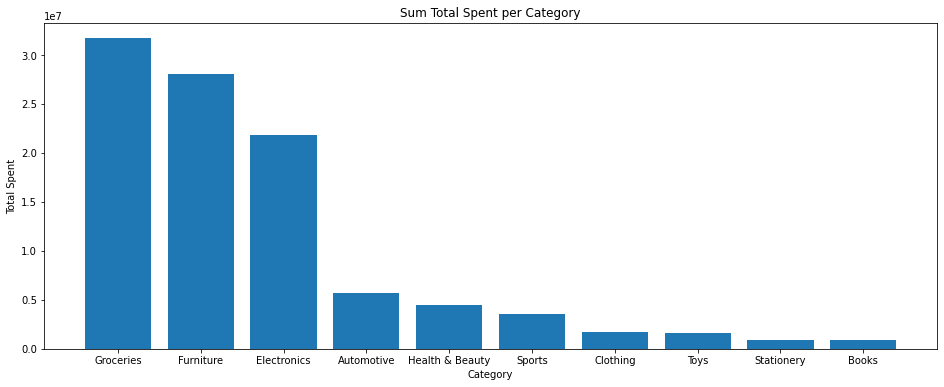

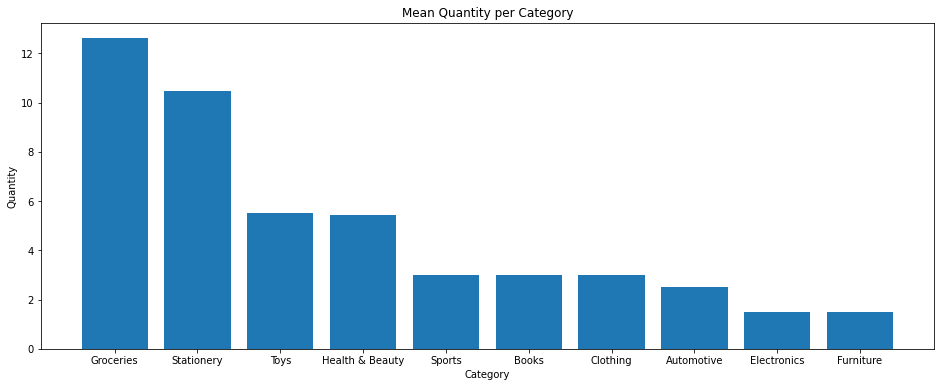

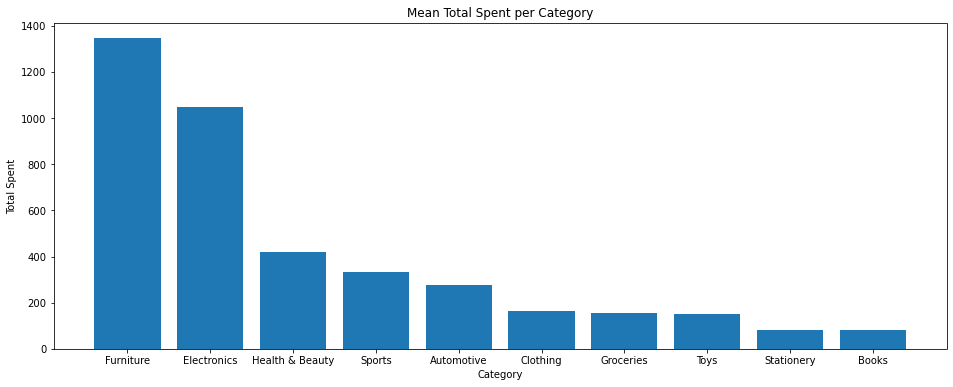

In [19]:
eda_plot('Category', 'Total_Spent', 'bar')
eda_plot('Category', 'Quantity', 'bar', 'mean')
eda_plot('Category', 'Total_Spent', 'bar', 'mean')

B) Analysis:
- Customers **spend significantly more to buy Groceries, Furniture, and Electronics** related products.
- **Furnitures and Electronics are extremely expensive**, indicated by low quantity and high spending.

C) Evaluation:
- There is a noticeable **spending pattern based on the Category of product** that customers buy.
- Using **Category to encode is useful in predicting expensive transactions**, as furnitures and electronics are more expensive than other categories by up to 3x.

### 2.6 Features Selection

## 3. Modelling

### 3.1 Data Pre-processing
#### 3.1.1 Encoding predictors

### 3.2 Linear Regression

### 3.3 Decision Tree Regression

### References:
- 2.5.1 Code for EDA Graph Plotter is built with ChatGPT. OpenAI. (2023, October 30). Re: Python Code for Creating Line and Bar Plots in EDA [Online Forum Comment]. ChatGPT by OpenAI. https://www.chatgpt.com

## >> End of Part 1 Submission

### 2.4 Features Creation
#### 2.4.0 Considerations for features:
- Logically related to customer spending habit.
- Makes sense that feature has relationship with customer spending; can be used as a useful predictor.
- Information should be available or guess-able when predicting for the future; No risk of target leakage.

In [20]:
STOP HERE

SyntaxError: invalid syntax (3031286301.py, line 1)

#### 2.4.3 isWeekend:
There is no work or school, applicable for most people, during weekends. Hence, there may be a pattern where there are more customers during weekends.

In [ ]:
df['isWeekend'] = df['Datetime'].dt.dayofweek // 5  
# 5 and 6, representing Saturday and Sunday, will take value of 1. Else 0.

#### 2.4.4 Customer_Type:
Does this customer have a tendency of spending at Retail Hypermarket? This field ranks the customers from 1 to 5, where 5 represents top spending customers. 

The range is kept small to avoid target leakage as the larger the range, the harder it is to accurate assume which level a customer falls in.

In [ ]:
# Customer Segmentation: How much does the customer spend
customer_segments = df.groupby('Customer_ID')['Total_Spent'].sum()
df['Customer_Class'] = df['Customer_ID'].map(customer_segments)

# Scale Customer Class to a 1-5 range
scaler = MinMaxScaler(feature_range=(1, 5))
df['Customer_Class'] = scaler.fit_transform(df['Customer_Class'].values.reshape(-1, 1))

#### 2.4.5 Product_Popularity:
How often is a particular product bought? Each product will be ranked from 1 to 10, where 10 representing the most popular products.

In [ ]:
product_popularity = df.groupby('Product_ID')['Quantity'].sum()
df['Product_Popularity'] = df['Product_ID'].map(product_popularity)

# Scale Product Popularity to a 1-10 range
scaler = MinMaxScaler(feature_range=(1, 10))
df['Product_Popularity'] = scaler.fit_transform(df['Product_Popularity'].values.reshape(-1, 1))

#### 2.4.5 Discount_Percentage:


In [ ]:
df['Discount_Percentage'] = (df['Discount'] / df['Total_Spent']) * 100

#### 2.4.6 Preview of Dataset:

In [ ]:
df.head()